# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another

## 1. Make classification data and get it ready

In [2]:
from sklearn.datasets import make_circles

In [3]:
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [6]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


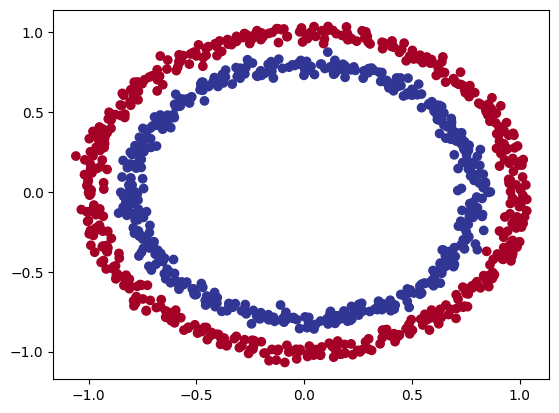

In [7]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note:** data we're working with is a toy data set, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and outpy shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test split

In [10]:
import torch

In [11]:
type(X)

numpy.ndarray

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)



In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

In [16]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [17]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model

In [18]:
# 1. Construct a model that subclasses nn.module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it ti the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
device

'cpu'

In [20]:
next(model_0.parameters()).device

device(type='cpu')

In [21]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0750, -0.2498],
                      [-0.1249, -0.3501],
                      [-0.1103,  0.5555],
                      [ 0.0942, -0.4466],
                      [-0.2535,  0.5304]])),
             ('0.bias', tensor([-0.6732,  0.0765,  0.5220,  0.4661,  0.5221])),
             ('1.weight',
              tensor([[-0.3126,  0.2901,  0.2307, -0.0961, -0.1146]])),
             ('1.bias', tensor([-0.2261]))])

In [23]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"First 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"First 10 labels:\n {y_test[:10]}")

Length of predictions: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])
First 10 predictions:
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.]])
First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Set up loss function and optimizer

Which loss_fn or optimizer should I use?

For example for regression we might want MAE or MSE.

For classification we might want binary cross entropy or categorical cross entropy.

As a reminder, the loss function measures how *wrong* your model's predictions are.

And for optimizer we have 2 main SGD and ADAM, there are more but these 2 are the *main*

* For the loss function we are going to use `torch.nn.BECWithLogitsLoss()`



In [24]:
# loss_fn = nn.BCELoss() # BCELoss - requires inputs to have gone through the sigmoid activation fucntion prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss - sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [25]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Training a model

TO train our model, we're going to build a training loop with the following steps:
1. Forward pass
2. Calculate the loss
3. Optimizer Zero grad
4. Loss backward (backpropagation)
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw logits

We cane convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary crossentropy and softmax for multiclass classification).

In [26]:
# View th first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device)[:5])
y_logits

tensor([[ 0.0885],
        [ 0.1054],
        [ 0.0078],
        [ 0.1115],
        [-0.0496]])

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.5221],
        [0.5263],
        [0.5020],
        [0.5278],
        [0.4876]])

In [29]:
# Find the predicted labels
y_preds = torch.round(y_pred_prob)
y_preds

# In full (logits -> prediction probabilities -> prediction labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 0.])

In [30]:
device

'cpu'

### 3.2 Building a training and testing loop

In [31]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  #loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #               y_train)
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate the loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69319, Acc: 51.50000 | Test loss: 0.69524, Test acc: 49.50%
Epoch: 50 | Loss: 0.69304, Acc: 50.50000 | Test loss: 0.69467, Test acc: 47.00%
Epoch: 100 | Loss: 0.69302, Acc: 51.12500 | Test loss: 0.69452, Test acc: 45.50%
Epoch: 150 | Loss: 0.69300, Acc: 50.75000 | Test loss: 0.69446, Test acc: 46.00%
Epoch: 200 | Loss: 0.69300, Acc: 50.62500 | Test loss: 0.69445, Test acc: 46.50%
Epoch: 250 | Loss: 0.69299, Acc: 51.00000 | Test loss: 0.69446, Test acc: 47.50%
Epoch: 300 | Loss: 0.69299, Acc: 51.00000 | Test loss: 0.69448, Test acc: 47.00%
Epoch: 350 | Loss: 0.69299, Acc: 50.87500 | Test loss: 0.69450, Test acc: 47.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.50000 | Test loss: 0.69452, Test acc: 47.00%
Epoch: 450 | Loss: 0.69298, Acc: 51.25000 | Test loss: 0.69455, Test acc: 47.00%
Epoch: 500 | Loss: 0.69298, Acc: 50.87500 | Test loss: 0.69456, Test acc: 46.50%
Epoch: 550 | Loss: 0.69298, Acc: 51.12500 | Test loss: 0.69458, Test acc: 46.50%
Epoch: 600 | Loss: 0.69298, Acc

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect It let's make some predictions and make them visual.

To do this we are going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [32]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("leper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py", 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

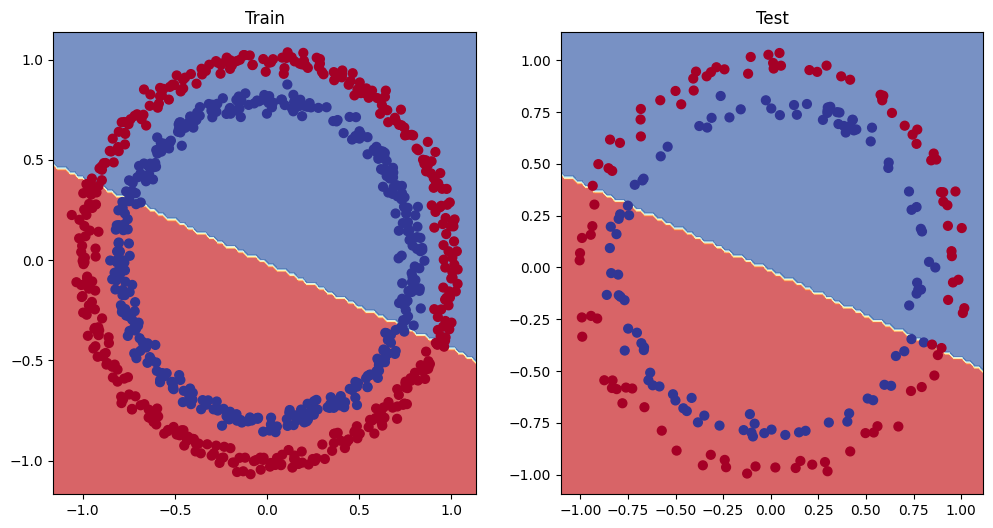

In [33]:
# plot_decision_boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [34]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages spped ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


In [36]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate the loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69396, Acc: 50.87500 | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.37500 | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12500 | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62500 | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12500 | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00000 | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00000 | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00000 | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00000 | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00000 | Test loss: 0.69468, Test acc: 46.00%


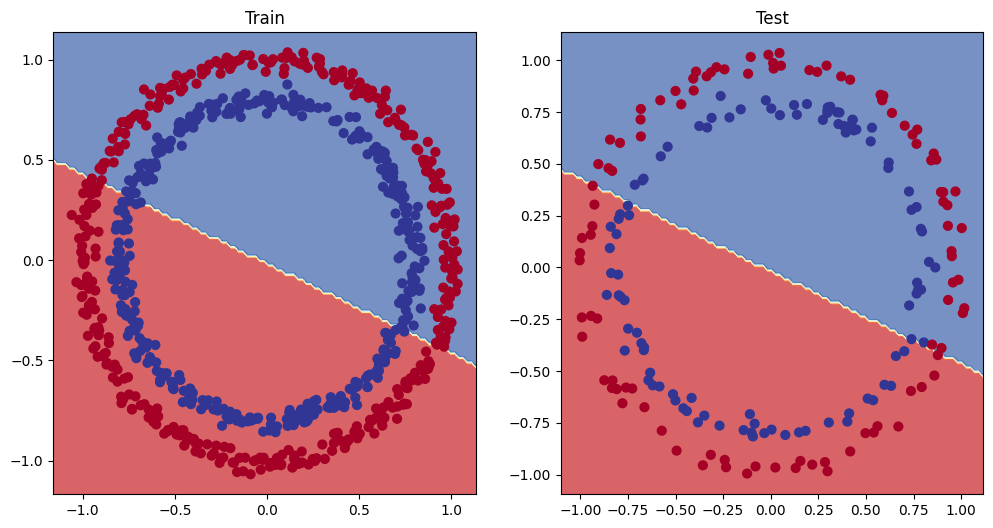

In [37]:
# plot_decision_boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [38]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

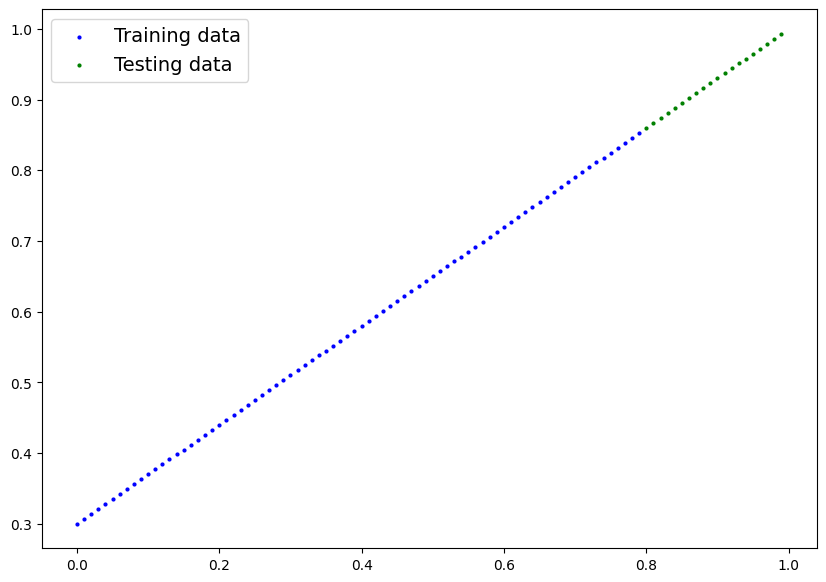

In [40]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line data

In [41]:
# same architecture as model_1 (but using nn.Sequantial())
model_2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
# Loss and optimizer

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [43]:
# Train model
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()

  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


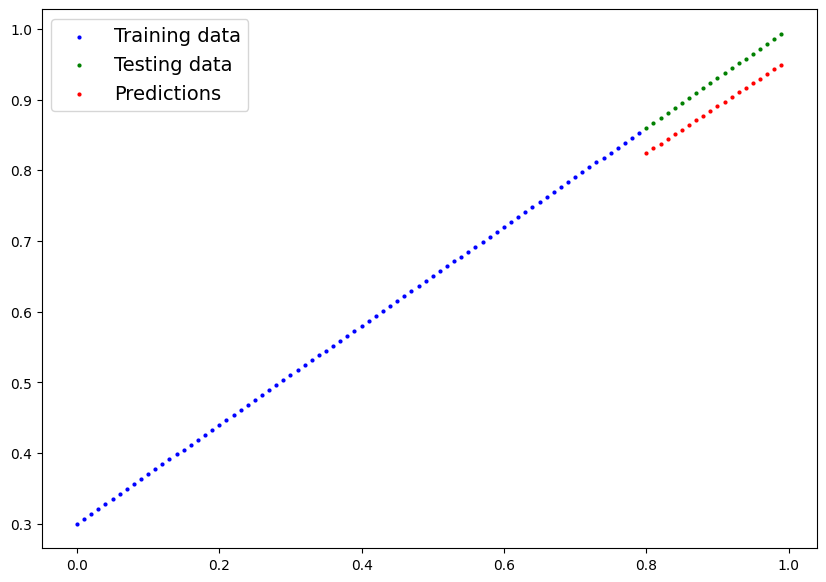

In [44]:
model_2.eval()
with torch.inference_mode():
  model_2_pred = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=model_2_pred.cpu())

## 6. The missing piece: non-linearity





### 6.1 Recreating non-linear data (red and blue circles)

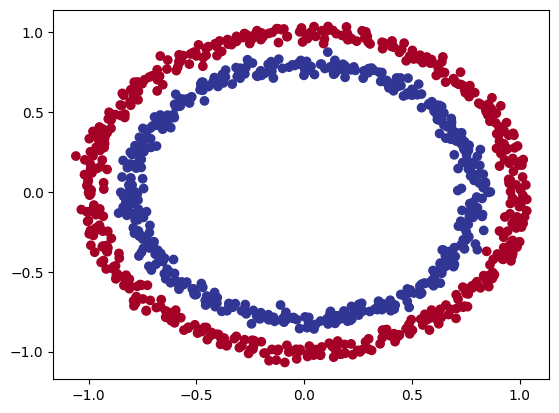

In [45]:
# Make and plot dat
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [46]:
# COnvert data to tensors and then to train and test splits
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building a model with non-linearity

In [47]:
# Build a model with non-linear activation functions
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 25)
    self.layer_2 = nn.Linear(25, 25)
    self.layer_3 = nn.Linear(25, 1)
    self.relu = nn.ReLU() # ReLU is non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=25, bias=True)
  (layer_2): Linear(in_features=25, out_features=25, bias=True)
  (layer_3): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
)

In [48]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [49]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.5f}")



Epoch: 0 | Loss: 0.69641, Acc: 50.00000 | Test loss: 0.69649, Test acc: 50.00000
Epoch: 50 | Loss: 0.69040, Acc: 56.62500 | Test loss: 0.69154, Test acc: 56.00000
Epoch: 100 | Loss: 0.68811, Acc: 61.00000 | Test loss: 0.68987, Test acc: 59.50000
Epoch: 150 | Loss: 0.68572, Acc: 68.62500 | Test loss: 0.68804, Test acc: 68.00000
Epoch: 200 | Loss: 0.68304, Acc: 70.50000 | Test loss: 0.68594, Test acc: 66.50000
Epoch: 250 | Loss: 0.67960, Acc: 73.00000 | Test loss: 0.68311, Test acc: 70.50000
Epoch: 300 | Loss: 0.67532, Acc: 75.12500 | Test loss: 0.67949, Test acc: 74.50000
Epoch: 350 | Loss: 0.66973, Acc: 77.12500 | Test loss: 0.67441, Test acc: 77.50000
Epoch: 400 | Loss: 0.66239, Acc: 78.75000 | Test loss: 0.66763, Test acc: 78.50000
Epoch: 450 | Loss: 0.65194, Acc: 79.62500 | Test loss: 0.65792, Test acc: 79.00000
Epoch: 500 | Loss: 0.63746, Acc: 84.75000 | Test loss: 0.64468, Test acc: 83.00000
Epoch: 550 | Loss: 0.61678, Acc: 92.25000 | Test loss: 0.62591, Test acc: 88.00000
Epoch: 

### 6.4 Evaluatin a model trained with non-linear activation functions

In [50]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

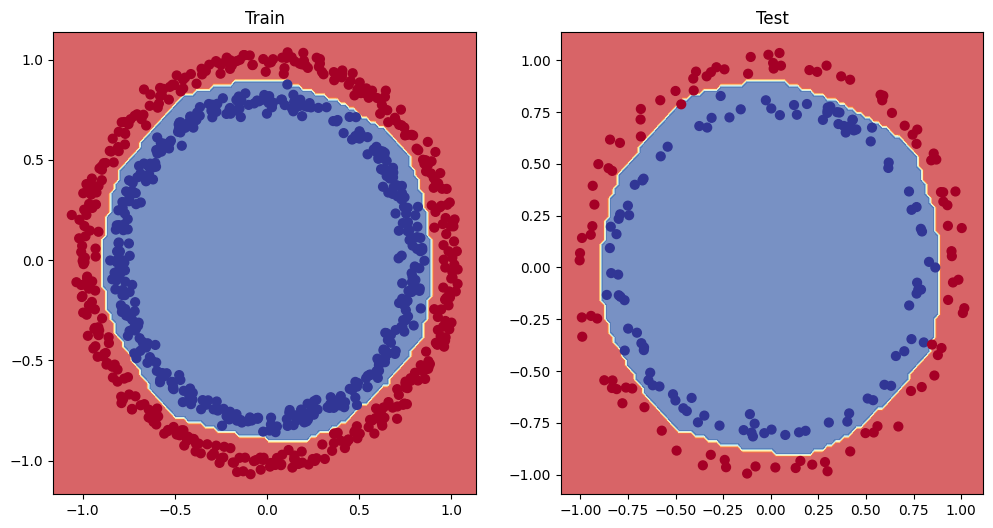

In [51]:
# plot_decision_boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activating functions

In [52]:
# create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [53]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

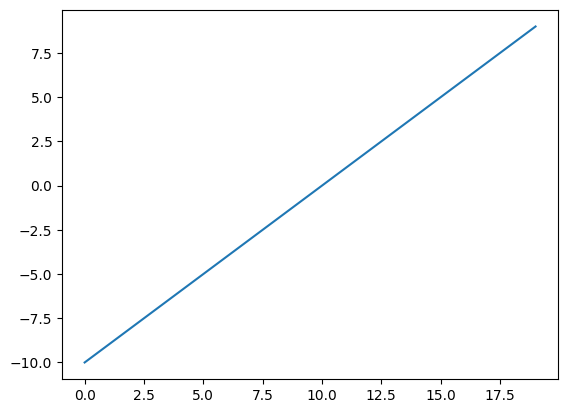

In [54]:
# Vizualize the tensor
plt.plot(A)

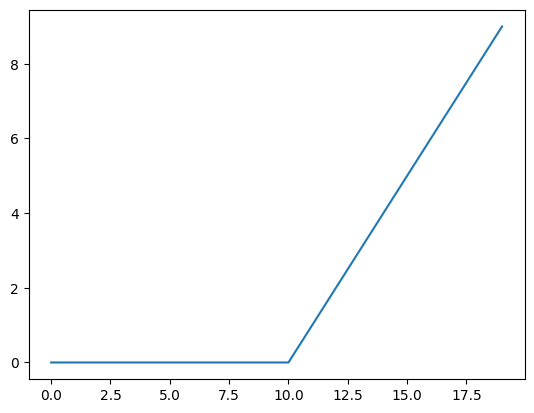

In [55]:
plt.plot(torch.relu(A))

In [56]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # unputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

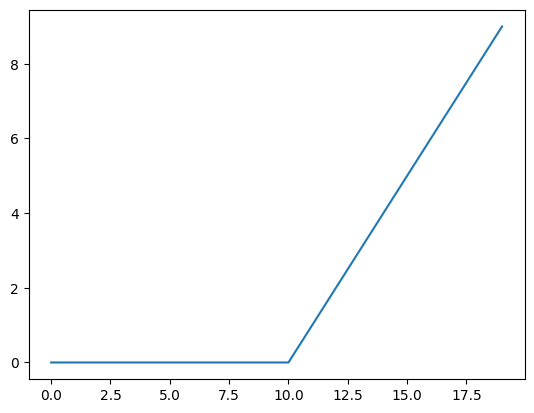

In [57]:
plt.plot(relu(A))


In [58]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

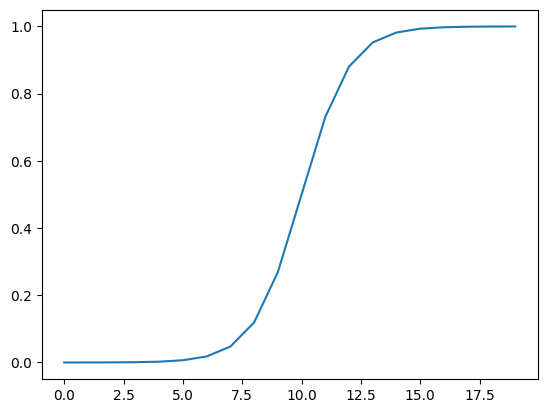

In [59]:
plt.plot(torch.sigmoid(A))

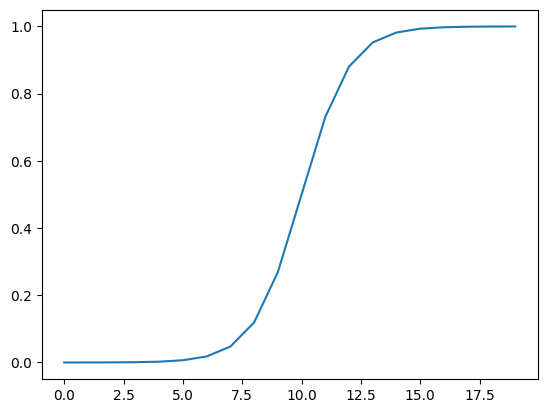

In [60]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (spam or not spam, cat vs. dog)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

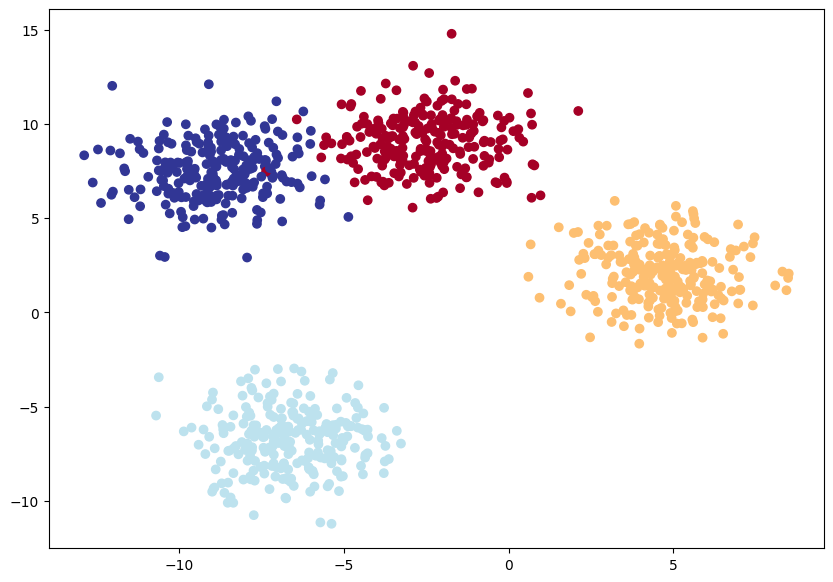

In [83]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into Tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. SPlit into Train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=42)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [84]:
# Create device agonstic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [109]:
# Build multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Instance of blob model

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

In [110]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [111]:
# create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an omptimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)


### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [112]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]])

In [113]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [114]:
# Convert logits to Pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [115]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [116]:
# Convert our model's pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [117]:
y_logits.argmax(dim=1)

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [118]:
y_blob_train.dtype

torch.int64

In [119]:
y_logits.dtype

torch.float32

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [120]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_test, X_blob_train = X_blob_test.to(device), X_blob_train.to(device)
y_blob_test, y_blob_train = y_blob_test.to(device), y_blob_train.to(device)

for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss= loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred=test_preds)

  # Print out the results
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.0432, Acc: 65.50% | Test loss: 0.5786, Test acc: 95.50%
Epoch: 10 | Loss: 0.1440, Acc: 99.12% | Test loss: 0.1304, Test acc: 99.00%
Epoch: 20 | Loss: 0.0806, Acc: 99.12% | Test loss: 0.0722, Test acc: 99.50%
Epoch: 30 | Loss: 0.0592, Acc: 99.12% | Test loss: 0.0513, Test acc: 99.50%
Epoch: 40 | Loss: 0.0489, Acc: 99.00% | Test loss: 0.0410, Test acc: 99.50%
Epoch: 50 | Loss: 0.0429, Acc: 99.00% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 60 | Loss: 0.0391, Acc: 99.00% | Test loss: 0.0308, Test acc: 99.50%
Epoch: 70 | Loss: 0.0364, Acc: 99.00% | Test loss: 0.0280, Test acc: 99.50%
Epoch: 80 | Loss: 0.0345, Acc: 99.00% | Test loss: 0.0259, Test acc: 99.50%
Epoch: 90 | Loss: 0.0330, Acc: 99.12% | Test loss: 0.0242, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [130]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [131]:
# Go from logits -> Pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4332e-03, 9.9757e-01, 1.0804e-11, 1.8271e-09],
        [3.4828e-03, 1.3697e-10, 6.8363e-04, 9.9583e-01],
        [2.8657e-12, 1.2266e-15, 9.9973e-01, 2.6959e-04],
        [3.2692e-03, 9.9673e-01, 9.5435e-08, 4.7619e-07],
        [9.9168e-01, 8.3089e-03, 1.4120e-10, 8.2969e-06],
        [4.5039e-04, 5.4287e-13, 2.5532e-04, 9.9929e-01],
        [1.6306e-11, 2.4030e-13, 9.9987e-01, 1.3003e-04],
        [9.9860e-01, 3.9485e-04, 5.9937e-08, 1.0045e-03],
        [3.0436e-14, 6.8303e-20, 9.9965e-01, 3.5218e-04],
        [9.9843e-01, 1.3657e-03, 9.0767e-09, 2.0006e-04]])

In [132]:
# Go from Pred probs -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

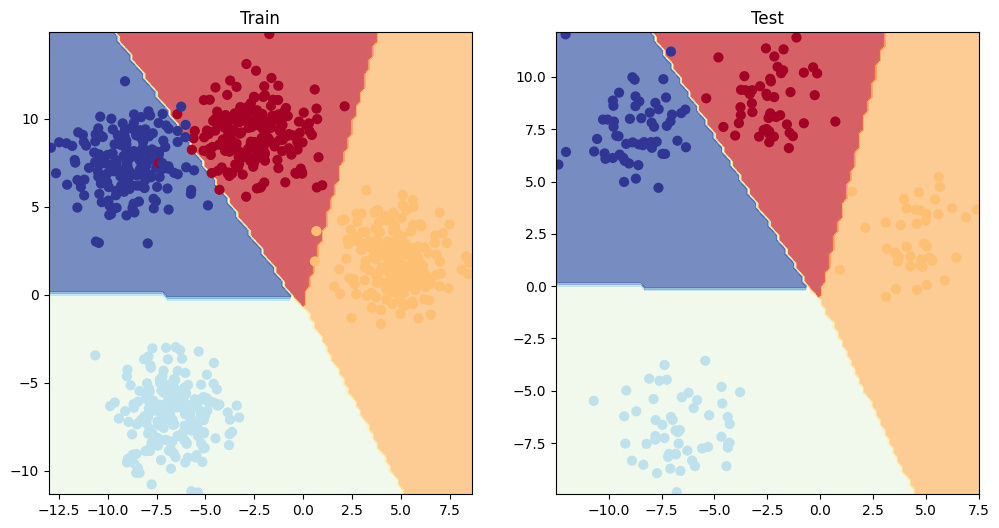

In [133]:
# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics (to evaluate our model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [134]:
#!pip install torchmetrics

In [140]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task='multiclass',
                                     num_classes=NUM_CLASSES).to(device)

print(f'Accuracy: {torchmetric_accuracy(y_preds, y_blob_test) * 100}%')

Accuracy: 99.5%
